In [1]:
##################
# IMPORT LIBRARIES
##################

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.tseries.offsets import Week
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

- **'id'** = interaction id
- **'Customer ID'** = UNIQUE CUSTOMER ID *unique = 19976 / value_counts.sum = 19976 / 17, 12, 8, 7, 7....*
- 'Customer Name' = PROBLEM multiple customer name of a single customer ID
*unique = 17738 / value_counts.sum = 20443 / 33, 17, 11, 11, 9.....*
- 'Customer Description' = Migration or special Gifted Status
- 'Plan' = plan_1 = 20442 / plan_2 = 1
- 'Product' = Supper Club = 20442 / renew test = 1
- 'Interval' = year = 20442 / day = 1
- 'Amount' = 69 = 20442 / 1 = 1
- **'Status'** = 'trialing', 'active', 'canceled', 'past_due', 'incomplete_expired'
- **'Created'** = interaction date *'Created (UTC)' is the first date in all rows: True*
- **'kind (metadata)'** = Migrated OG Member 552
- **''Cancel At Period End'** = False : 16878 / True : 3565





In [2]:
##################
# VISUAL SETTINGS
##################

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 12
sns.set_palette("viridis")

In [3]:
##################
# LOADING CSV
##################

# Toggle this flag to True in production
RENAME_FILES = False

data_dir = 'data'

# List and sort files by creation time
files = [
    os.path.join(data_dir, f)
    for f in os.listdir(data_dir)
    if os.path.isfile(os.path.join(data_dir, f)) and f.endswith('.csv')
]

sorted_files = sorted(files, key=os.path.getctime, reverse=True)

# Loop over files
for file_path in sorted_files:
    created_at = datetime.fromtimestamp(os.path.getctime(file_path))
    timestamp_str = created_at.strftime('%Y-%m-%d_%H-%M-%S')
    original_name = os.path.basename(file_path)
    new_name = f"{timestamp_str}_{original_name}"
    new_path = os.path.join(data_dir, new_name)

    if RENAME_FILES:
        if not original_name.startswith(timestamp_str):
            os.rename(file_path, new_path)
            print(f"Renamed: {original_name} → {new_name}")
            file_path = new_path
        else:
            print(f"Already renamed: {original_name}")
    else:
        print(f"[DEV] Would rename: {original_name} → {new_name}")



df_raw = pd.read_csv(file_path)

[DEV] Would rename: DishpatchSubscriptionData_NIklas_Sanitised - subscriptions (2).csv → 2025-05-27_20-40-12_DishpatchSubscriptionData_NIklas_Sanitised - subscriptions (2).csv


In [4]:
##################
# DATA PREPROCESSING
# 1
###################

df = df_raw.copy()

# Date conversion
date_cols = [col for col in df.columns if '(UTC)' in col]
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Order by Created (UTC)
df = df.sort_values(by='Created (UTC)')

# Column selection
df = df[['id', 
        'Customer ID',
        'Customer Name',
        'Status',
        'Cancellation Reason',
        'Created (UTC)',
        'Start (UTC)',
        'Start Date (UTC)',
        'Current Period Start (UTC)',
        'Current Period End (UTC)',
        'Trial Start (UTC)',
        'Trial End (UTC)',
        'Canceled At (UTC)',
        'Ended At (UTC)',
       'senderShopifyCustomerId (metadata)']]


# Renaming and selection
df.rename(columns={'Customer ID' : 'customer_id',
                   'Customer Name' : 'customer_name',
                   'Status' : 'status',
                   'Created (UTC)': 'created_utc',
                   'Start (UTC)': 'start_utc',
                   'Start Date (UTC)': 'start_date_utc',
                   'Current Period Start (UTC)': 'current_period_start_utc',
                   'Current Period End (UTC)': 'current_period_end_date_utc',
                   'Trial Start (UTC)': 'trial_start_utc',
                   'Trial End (UTC)': 'trial_end_utc',
                   'Canceled At (UTC)': 'canceled_at_utc',
                   'Ended At (UTC)': 'ended_at_utc',
                   'senderShopifyCustomerId (metadata)': 'is_gifted_member'
                }, inplace=True)

df['is_gifted_member'] = df['is_gifted_member'].notna()
df['extended_trial_period'] = (df['trial_end_utc'] + pd.DateOffset(days=14))

# Reference date for analysis
reference_date = datetime.now()

In [5]:
customer_df = df.groupby('customer_name').agg({
    'customer_id': 'first',
    'created_utc': 'first',
    'status': 'last',
    'current_period_start_utc': 'last',
    'current_period_end_date_utc': 'last',
    'trial_start_utc': 'first',
    'trial_end_utc': 'first',
    'canceled_at_utc': 'last',
    'ended_at_utc': 'last',
    'is_gifted_member': 'any',
    'id': 'count'}).rename(columns={'id': 'subscription_count'})

In [6]:
clean_customer_df = customer_df[customer_df['subscription_count'] <= 4]

print(f"Before cleaning: {len(customer_df):,} customers")
print(f"After cleaning: {len(clean_customer_df):,} customers")
print(f"Removed: {len(customer_df) - len(clean_customer_df)} suspicious customers")

customer_df = clean_customer_df.copy()

Before cleaning: 17,738 customers
After cleaning: 17,710 customers
Removed: 28 suspicious customers


In [7]:
# Cancel During Trial
customer_df['cancel_during_trial'] = (customer_df['canceled_at_utc'] < customer_df['trial_end_utc']) & (customer_df['canceled_at_utc'].notna())

# Cancel During Churn (14 days after trial end)
customer_df['cancel_during_churn'] = (customer_df['canceled_at_utc'] > customer_df['trial_end_utc']) & (customer_df['canceled_at_utc'] < customer_df['trial_end_utc'] + pd.DateOffset(days=14)) & (customer_df['canceled_at_utc'].notna())

# Cancel During Trial + Churn
customer_df['cancel_during_trial_churn'] = (customer_df['cancel_during_trial'] == True) & (customer_df['cancel_during_churn'] == True)

# Cancel After Churn
customer_df['cancel_after_churn'] = (customer_df['canceled_at_utc'] > customer_df['trial_end_utc'] + pd.DateOffset(days=14)) & (customer_df['canceled_at_utc'].notna())

# Full Menber (not gifted, active)
customer_df['full_member'] = (customer_df['is_gifted_member'] == False) & (customer_df['status'] == 'active')

In [8]:
# Plot 1: Evolution of total active users (not gifted) per week

def plot_active_users_weekly(customer_df):
    """Plot 1: Weekly evolution of total active non-gifted users"""
    
    # Filter non-gifted members
    non_gifted = customer_df[customer_df['is_gifted_member'] == False].copy()
    
    # Get date range
    start_date = non_gifted['created_utc'].min()
    end_date = datetime.now()
    
    # Create weekly date range
    weekly_dates = pd.date_range(start=start_date, end=end_date, freq='W')
    active_counts = []
    
    for week_date in weekly_dates:
        # Count users who were active at this point in time
        active_at_week = non_gifted[
            (non_gifted['created_utc'] <= week_date) &  # User existed
            ((non_gifted['ended_at_utc'].isna()) | (non_gifted['ended_at_utc'] > week_date)) &  # Not ended
            ((non_gifted['canceled_at_utc'].isna()) | (non_gifted['canceled_at_utc'] > week_date))  # Not canceled
        ]
        active_counts.append(len(active_at_week))
    
    # Create plot
    plt.figure(figsize=(12, 6))
    plt.plot(weekly_dates, active_counts, linewidth=2, marker='o', markersize=4)
    plt.title('Evolution of the total number of active (non-gifted) users per week', fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Number of active users')
    plt.grid(True, alpha=0.3)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return weekly_dates, active_counts

In [ ]:
def plot_new_users_and_cancellations_weekly(customer_df):
    """Plot 2: Weekly new users and cancellations during trial/churn"""
    
    # Filter non-gifted members
    non_gifted = customer_df[customer_df['is_gifted_member'] == False].copy()
    
    # Group by week of creation (using resample)
    non_gifted_indexed = non_gifted.set_index('created_utc')
    
    # New users per week
    new_users_weekly = non_gifted_indexed.resample('W').size()
    
    # New users who didn'tcanceled during trial + churn period
    trial_churn_cancelers = non_gifted[
        (non_gifted['cancel_during_trial'] == True) | 
        (non_gifted['cancel_during_churn'] == True)
    ]
    trial_churn_indexed = trial_churn_cancelers.set_index('created_utc')
    trial_churn_weekly = trial_churn_indexed.resample('W').size()
    
    # Align the series
    all_weeks = new_users_weekly.index.union(trial_churn_weekly.index)
    
    new_users_aligned = new_users_weekly.reindex(all_weeks, fill_value=0)
    trial_churn_aligned = trial_churn_weekly.reindex(all_weeks, fill_value=0)
    
    # Create plot
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Bar plot for new users
    bars1 = ax.bar(all_weeks, new_users_aligned.values, alpha=0.7, 
                   label='Nouveaux utilisateurs (non-gifted)', color='skyblue', width=5)
    
    # Bar plot for cancellations during trial/churn
    bars2 = ax.bar(all_weeks, trial_churn_aligned.values, alpha=0.8, 
                   label='Annulés pendant trial/churn', color='salmon', width=5)
    
    # Add percentage labels on top of cancellation bars
    for i, (week, new_count, cancel_count) in enumerate(zip(all_weeks, new_users_aligned.values, trial_churn_aligned.values)):
        if new_count > 0:
            percentage = (cancel_count / new_count) * 100
            if cancel_count > 0:
                ax.text(week, cancel_count + max(new_users_aligned.values) * 0.01, 
                       f'{percentage:.1f}%', ha='center', va='bottom', fontsize=8)
    
    ax.set_title('Évolution hebdomadaire: nouveaux utilisateurs vs annulations (trial/churn)', 
                fontsize=14, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Nombre d\'utilisateurs')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Calculate overall statistics
    total_new = new_users_aligned.sum()
    total_canceled = trial_churn_aligned.sum()
    overall_cancel_rate = (total_canceled / total_new) * 100 if total_new > 0 else 0
    
    print(f"\nStatistiques globales:")
    print(f"Total nouveaux utilisateurs: {total_new}")
    print(f"Total annulés pendant trial/churn: {total_canceled}")
    print(f"Taux d'annulation trial/churn: {overall_cancel_rate:.2f}%")
    
    return new_users_aligned, trial_churn_aligned

Generating chart 1: Active users per week


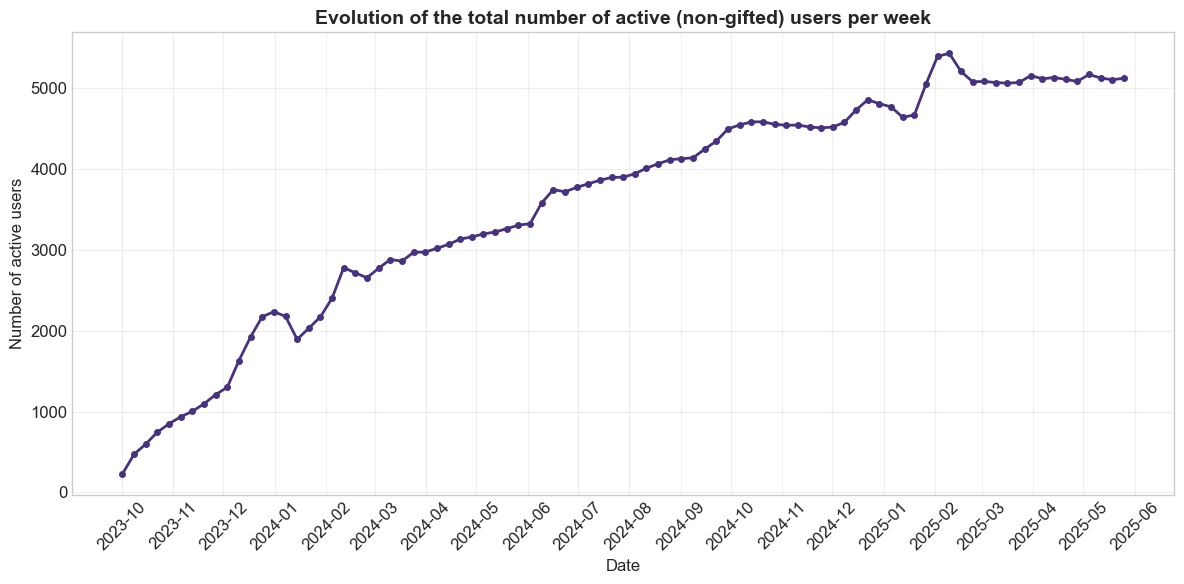

Current active users: 5125

Generating chart 2: New users and cancellations


NameError: name 'plot_new_users_and_cancellations_weekly' is not defined

In [9]:
# Execute both plots
if __name__ == "__main__":
    # Plot 1: Active users evolution
    print("Generating chart 1: Active users per week")
    weekly_dates, active_counts = plot_active_users_weekly(customer_df)
    
    print(f"Current active users: {active_counts[-1] if active_counts else 0}")
    
    # Plot 2: New users and cancellations
    print("\nGenerating chart 2: New users and cancellations")
    new_users, cancellations = plot_new_users_and_cancellations_weekly(customer_df)